In [43]:
#%matplotlib widget
import numpy as np                             
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import find_peaks
from scipy.integrate import odeint, solve_ivp
from matplotlib.gridspec import GridSpec
from datetime import datetime
import scipy.stats as stats
import pandas as pd
import pickle
import tqdm
from tqdm import tqdm
import time

import sys
sys.path.append('../../')
from Functions_common_for_model_and_experiments import *
sys.path.append('../')
from Multiple_pulses_experiments import Functions_for_plot_style
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Import and load experimental file
file_path="../Multiple_pulses_experiments/Output_files/"
dataset_experimental = pd.read_pickle(file_path+"Dataset.pkl")

# Parameters

In [3]:
time_scale = 1.103 #1.103 #103
mol_scale = 1
Pars = {
    'kc1': mol_scale*time_scale*10,             # production of p53
    'kc20': time_scale*10,             # degradation of p53 by mdm2
    'kc3': mol_scale*0.12,           # degradation of p53 by mdm2
    'kc4': time_scale*0.01/mol_scale,           # production of mdm2 - mRNA
    'kc5': time_scale*0.25,           # degradation of mdm2 - mRNA
    'kc6': time_scale*10,             # production of mdm2
    'kc7': time_scale*1,              # degradation of mdm2
}


Mean period params (h):  5.474187500006718


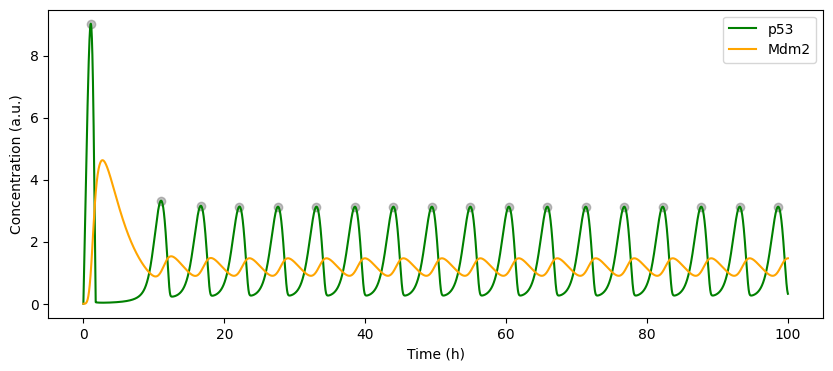

In [4]:
simT = 100 # [h]
maxstep = 0.001 # [h]
kc1, kc20,kc3,kc4,kc5,kc6,kc7 = unpack_Pars_list(Pars)
sol = solve_ivp(f_p53, [0, simT], [0,0,0], max_step = maxstep, method = 'RK45', args = (kc1,kc20,kc3,kc4,kc5,kc6,kc7))

# Plots
plt.figure(figsize=(10,4))
peaks, _ = find_peaks(sol.y[2], prominence=0.1)
plt.plot(sol.t, sol.y[2], color = "green", label = "p53")
plt.plot(sol.t, sol.y[1], color = "orange", label = "Mdm2")
plt.scatter(sol.t[peaks], sol.y[2,peaks], color = "gray", alpha = 0.5)

plt.legend()
plt.xlabel("Time (h)")
plt.ylabel("Concentration (a.u.)")
mean_T = np.mean(np.diff(sol.t[peaks[1:]]))
print("Mean period params (h): ",mean_T)

# Fig 2B bottom: single-mode entrainment

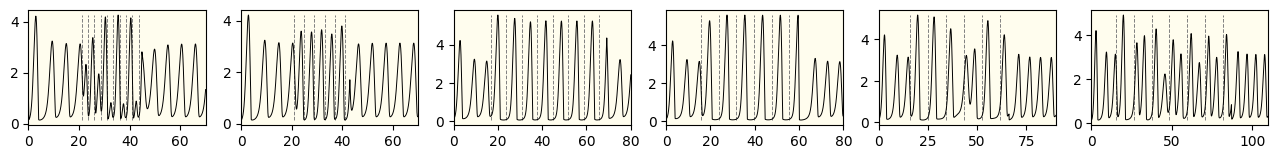

In [5]:
Aosc = 0.4
kc1, kc20,kc3,kc4,kc5,kc6,kc7 = unpack_Pars_list(Pars)
grouped = dataset_experimental.groupby("nutlin_period [hour]").agg({"ton": "first", "toff": "first", "time": list}).reset_index()
# Extract nutlin periods and corresponding t_on and t_off lists
Tosc_vec = grouped["nutlin_period [hour]"].tolist()
tonvec = np.array(grouped["ton"])/6
toffvec = np.array(grouped["toff"])/6
dt = 0.001
init_cond = np.array([0.08243579, 2, 1])
simTvec = [70,70,80,80,90,110]
fig, axs = plt.subplots(1,len(Tosc_vec),figsize=(16,1.5))

for i, Tosc in enumerate(Tosc_vec):
    simT = simTvec[i]
    t = np.arange(0, simT, dt) 
    npulses = round((toffvec[i]+Tosc/2-tonvec[i])/Tosc)
    time_nut_peaks = tonvec[i]+Tosc*np.arange(0,npulses,1)
    x,kc2 = odeRungeKutta4_p53(f_p53,init_cond, dt, simT, Aosc, Tosc, tonvec[i], toffvec[i], kc1,kc20,kc3,kc4,kc5,kc6,kc7)
    axs[i].vlines(time_nut_peaks, min(x[:,2]),max(x[:,2]), linestyle = '--', color = "gray", linewidth = 0.7)
    axs[i].plot(t,x[:,2], color = "black", linewidth=0.7)
    #axs[i].set_xlabel("Time (h)")
    axs[i].set_facecolor(color_background)
    axs[i].set_xlim(left=0, right = simT)
#axs[0].set_ylabel("p53 (a.u.)")
filename = f"Single_cell_entrainment.svg"
plt.savefig("./Figures/"+filename)

# Fig 3F: Multistabilities

In [6]:
def plot_2_traces_multistability(xvec,dt,simT,tON,tOFF,Tosc,xlim,colors):
    t = np.arange(0, simT, dt) 
    fig = plt.figure(figsize=(10,1.5))
    gs = GridSpec(1, 2, width_ratios=[3, 1])  # 2 columns, 1 row, first plot 3 times wider

    ax1 = fig.add_subplot(gs[0])
    t0 = 0
    #ax1.plot(t,kc2-5, alpha = 0.5, color = "gray", ls = "--")
    for i,x in enumerate(xvec):
        ax1.plot(t-t0, x[:,2], label = "Cell "+str(i+1), color = colors[i])

        plt.xlim(xlim)
        ax1.set_facecolor(color_background)
        #plt.plot(t,x[:,-1], alpha = 0.1)
    ax1.set_xlabel("Time (h)")
    ax1.set_ylabel("p53 level (a.u.)")
    ax1.legend()
    npulses = int((tOFF-tON)/Tosc)
    time_nut_peaks = tON+Tosc*np.arange(0,npulses,1)-t0
    ax1.vlines(time_nut_peaks, min(x[:,2]),max(x[:,2]), linestyle = '--', color = "gray", linewidth = 1)

    ax2 = fig.add_subplot(gs[1])
    for i,x in enumerate(xvec):
        ax2.plot(x[int(simT/2/dt):int(tOFF/dt),1], x[int(simT/2/dt):int(tOFF/dt),2], label = "p53", color = colors[i])
        #ax2.plot(x_noise[-int(50/dt):,1],x_noise[-int(50/dt):,2], color = "red")
        ax2.set_xlabel("Mdm2 level (a.u.)")
        ax2.set_ylabel("p53 level (a.u.)")
        ax2.set_facecolor(color_background)
        #plt.plot(t,x[:,-1], alpha = 0.1)
    filename = f"Multistability{Tosc}.svg"
    plt.savefig("./Figures/"+filename)
    plt.show()

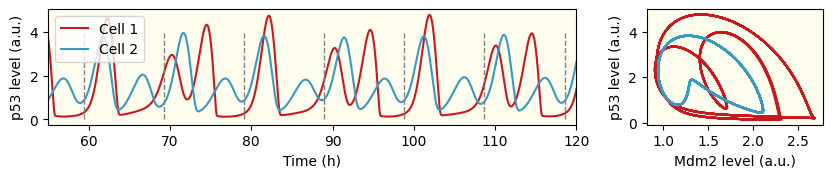

In [7]:
Aosc = 0.4
Tnat = mean_T
Tosc = 1.8*Tnat
kc1, kc20,kc3,kc4,kc5,kc6,kc7 = unpack_Pars_list(Pars)
dt = 0.005
simT = 300 # [h]
tON = 20
tOFF = simT
t = np.arange(0, simT, dt) 
init_cond_mRNA_vec = np.linspace(0,1,10)
xvec = []

colors = [color_3_to_2,color_2_to_1]
xlim = [55,120]


for init_cond_mRNA in init_cond_mRNA_vec[1:3]:
    init_cond = np.array([init_cond_mRNA,1,0])#dmdt,dMfreedt,dpdt,dMbounddt, dndt
    x,kc2 = odeRungeKutta4_p53(f_p53,init_cond, dt, simT, Aosc, Tosc, tON, tOFF, kc1,kc20,kc3,kc4,kc5,kc6,kc7) 
    xvec.append(x)

plot_2_traces_multistability(xvec,dt,simT,tON,tOFF,Tosc,xlim,colors)

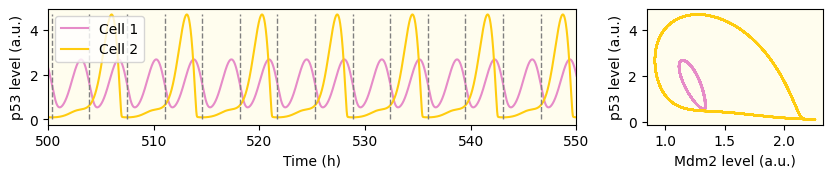

In [8]:
Aosc = 0.21
Tnat = mean_T
Tosc = 0.65*Tnat 
kc1, kc20,kc3,kc4,kc5,kc6,kc7 = unpack_Pars_list(Pars)
dt = 0.005
simT = 600 # [h]
tON = 20
tOFF = simT

colors = [color_1_to_1,color_1_to_2]
xlim = [500,550]
t = np.arange(0, simT, dt) 
init_cond_mRNA_vec = np.linspace(0,1,10)
xvec = []
for init_cond_mRNA in init_cond_mRNA_vec[1:3]:
    init_cond = np.array([init_cond_mRNA,1,0])#dmdt,dMfreedt,dpdt,dMbounddt, dndt
    x,kc2 = odeRungeKutta4_p53(f_p53,init_cond, dt, simT, Aosc, Tosc, tON, tOFF, kc1,kc20,kc3,kc4,kc5,kc6,kc7) 
    xvec.append(x)

plot_2_traces_multistability(xvec,dt,simT,tON,tOFF,Tosc,xlim,colors)

# Fig 3G: Arnold Tongues

In [9]:
from Arnold_tongues_pars import *

Aosc_vec = simulation_parameters["Aosc_vec"]
Tosc_vec = simulation_parameters["Tosc_vec"]

x_list_of_lists = []
for i in np.arange(0,partitions):
    with open(f"./Output/arnold_tongue_200x200/partition_{i}.pkl", 'rb') as f:
        # Load the data from the file
        x_list = pickle.load(f)
        x_list_of_lists = x_list_of_lists + x_list
# Extract p53 traces and put in a matrix for computing Arnold Tongues
x_jk = x_list_of_lists[0][2]
AT_matrix = np.zeros((len(Aosc_vec),len(Tosc_vec),len(x_jk)))
for i in range(len(x_list_of_lists)):
    j= x_list_of_lists[i][1][0]
    k = x_list_of_lists[i][1][1]
    x_jk = x_list_of_lists[i][2]
    AT_matrix[j][k][:] = x_jk

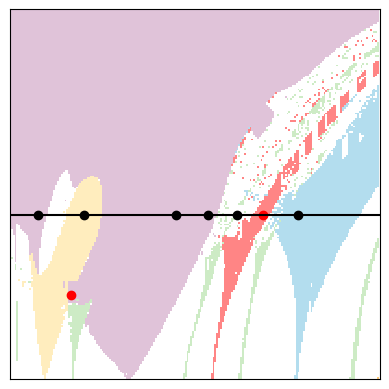

In [10]:
import matplotlib as mpl
transient = 100
# Find rotation number:
t = np.arange(0,simulation_parameters["simT"],simulation_parameters["dt"]*save_every_n_timesteps)
rot_num_vec = np.zeros((len(Aosc_vec),len(Tosc_vec)))

for j,Aosc in enumerate(Aosc_vec):
    for k,Tosc in enumerate(Tosc_vec):
        x = AT_matrix[j][k][:]
        peaks, _ = find_peaks(x, prominence = 0.2)
        time_peaks = t[peaks]
        new_T = np.mean(np.diff(time_peaks[time_peaks>transient]))
        rot_num_vec[j,k] = Tosc/new_T


low_modes = np.array([0, 0.5,1,1.5,2,2.5,3])
#rationals1 = np.array([0, 1/5, 1/4, 1/3, 2/5, 1/2, 3/5, 2/3, 3/4, 4/5]);
rationals1 = np.array([0, 1/3, 1/2, 2/3]);
rationals2 = 1.+rationals1
rationals3 = 2.+rationals1
modes = np.append(np.append(rationals1,rationals2),rationals3)
modes = np.append(modes,3)

# Draw Arnold tongues colors
fig2,ax2 = plt.subplots()
bounds = []
for mode_ith,mode in enumerate(modes):
    bounds = np.append(bounds, 0.995*mode) #lower bound
    bounds = np.append(bounds, 1.005*mode) #higher bound
bounds = np.append(bounds, [3.3]) #final bound
bounds[0:2] = np.array([-0.01,0.05]) # Zero mode

#colors
yellow = np.array([255, 237, 190])/255
pink = np.array([224, 195, 217])/255
lightblue = np.array([179, 221, 238])/255
green =np.array([196, 235, 185])/255
white = np.array([1,1,1])
black = np.array([0,0,0])
red = np.array([255,133,133])/255
orange = np.array([255,203,120])/255
bluemarine = np.array([0,166,166])/255
gray = np.array([192,192,192])/255

#Define colormap
colors_lowmodes = [bluemarine, yellow, pink, red, lightblue, orange, green]
colors_highmodes = "#CDEBC5"
colors = []
i=0
for mode_ith,mode in enumerate(modes):
    if mode in low_modes:
        colors.append(colors_lowmodes[i])
        colors.append(white)
        i=i+1
    else:
        colors.append(colors_highmodes)
        colors.append(white)

cmap = (mpl.colors.ListedColormap(colors))

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

#fig2.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),spacing='proportional', ticks=modes, label = "Rotation number")
ax2.matshow(rot_num_vec, cmap=cmap, norm=norm, aspect = 1, origin = "lower")
plt.hlines(88,xmin = 0, xmax = 200, color = "black")
exp_Aosc_point = [88,88,88,88,88,88]
exp_Tosc_points = [15, 40, 90, 107, 123,156]
exp_multistability_points = [[33, 137],[45,88]]
plt.scatter(exp_Tosc_points, exp_Aosc_point, color = "black")
plt.scatter(exp_multistability_points[0], exp_multistability_points[1],color = "red")
plt.xticks([])
plt.yticks([])
plt.xlim([0,200])
plt.savefig("./Figures/Arnold_tongues200x200.svg")
plt.show()

# Figure 4A: Mode-hopping

### Single cells short simulations 

In [21]:
def plot_mode_hopping_model(seed, D,x0,dt,simT,Aosc,Tosc,tON,tOFF,f_p53,Pars,title, color_background):
    np.random.seed(seed)
    x,_ = odeEuler_p53_with_noise(f_p53,x0,dt,simT,Aosc,Tosc,tON,tOFF,D, **Pars)
    #x_noiseless,kc2 = odeEuler_p53_with_noise(f_p53,x0,dt,simT,Aosc,Tosc,tON,tOFF,0, **Pars)
    t = np.arange(0,simT,dt)
    fig, ax = plt.subplots(figsize=(3.5,1))
    plt.plot(t, x[:,2], label = "p53", color = "black")
    #plt.plot(t, x[:,1], label = "mRNA", color = "orange")
    #plt.plot(t, x_noiseless[:,1], label = "mRNA", color = "red")
    #plt.plot(t, x_noiseless[:,2], label = "p53", color = "gray", alpha =0.5)
    p53 = x[:,2]
    #plt.plot(np.arange(0,simT,dt), (kc2-10)/2, label = "p53", color = "gray")
    #plt.xlim([time_nut_peaks[-4],simT])
    npulses = int((tOFF-tON)/Tosc)
    time_nut_peaks = tON+Tosc*np.arange(0,npulses,1)
    ax.vlines(time_nut_peaks, min(x[:,2]),max(x[:,2]), linestyle = '--', color = "gray", linewidth = 0.7)

    plt.vlines([tON,tOFF], 0, 5, color = "gray", linestyle = "--")
    plt.xlabel("Time (h)")
    plt.ylabel("p53 (a.u.)")
    Functions_for_plot_style.set_plot_properties(ax, style_left_bottom_axis_only = True, background_color=color_background)
    plt.savefig("./Figures/mode_hopping_trace_"+title+"_model.svg")


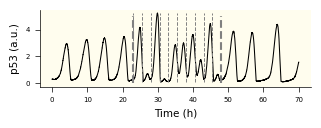

In [22]:
plot_mode_hopping_model(seed = 1,
                        D = 0.0001,
                        x0 = [0.15, 1.38030638, 0.29319877],
                        dt = 0.0001,
                        simT = 70,
                        Aosc = 0.4,
                        Tosc=2.5,
                        tON=23,
                        tOFF = 48,
                        f_p53 = f_p53,
                        Pars = Pars,
                        title = "25h",
                        color_background = color_background)

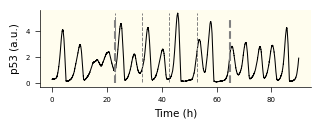

In [23]:
plot_mode_hopping_model(seed = 34,
                        D = 0.0001,
                        x0 = [0.15, 1.38030638, 0.29319877],
                        dt = 0.0001,
                        simT = 90,
                        Aosc = 0.4,
                        Tosc=9.9,
                        tON=23,
                        tOFF = 65,
                        f_p53 = f_p53,
                        Pars = Pars,
                        title = "9h",
                        color_background = color_background)

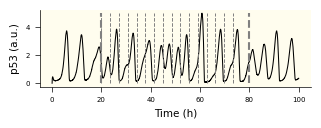

In [24]:
plot_mode_hopping_model(seed = 1,
                        D = 0.00005,
                        x0 = [0.22222222, 1.        , 0.        ],
                        dt = 0.0005,
                        simT = 100,
                        Aosc = 0.21,
                        Tosc=0.65*Tnat,
                        tON=20,
                        tOFF = 80,
                        f_p53 = f_p53,
                        Pars = Pars,
                        title = "final",
                        color_background = color_background)

### Three levels of noise long simulations

In [25]:
Dvec = [0.00001,0.00005, 0.0001]
title_noise = ["low_noise", "mid_noise", "high_noise"]
x0 = np.array([0.22222222, 1.        , 0.        ])
dt = 0.0005
simT = 1250 #tOFF+tON
Aosc = 0.21
Tosc = 0.65*Tnat
tON = 20
tOFF = simT #20*Tosc+tON
xvec = []
x01 = np.array([0.22222222, 1.        , 0.        ])
x_runge1,kc2 = odeRungeKutta4_p53(f_p53,x01,dt,simT,Aosc,Tosc,tON,tOFF, **Pars)
x02 = np.array([0.11111111, 1.        , 0.        ])
x_runge2,kc2 = odeRungeKutta4_p53(f_p53,x02,dt,simT,Aosc,Tosc,tON,tOFF, **Pars)
for i,D in enumerate(Dvec):
    np.random.seed(1)
    x,kc2 = odeEuler_p53_with_noise(f_p53,x0,dt,simT,Aosc,Tosc,tON,tOFF,D, **Pars)
    t = np.arange(0,simT,dt)

    xvec.append(x)

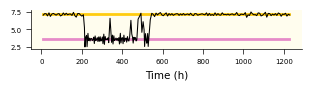

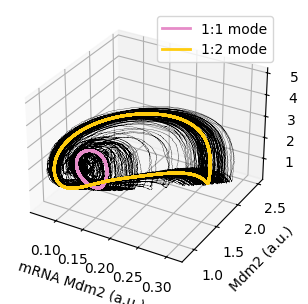

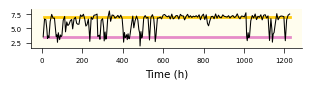

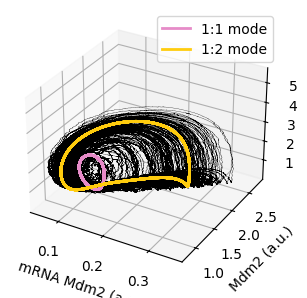

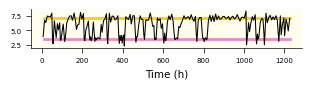

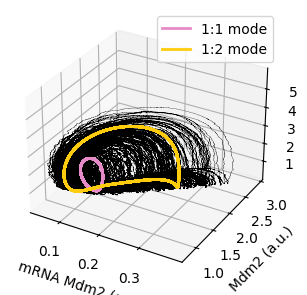

In [26]:
transient = int(tON/dt)
peaks2,_ = find_peaks(x_runge2[transient:,2])
peaks1,_ = find_peaks(x_runge1[transient:,2])
stable_period2 = np.diff(peaks2)[-1]*dt
stable_period1 = np.diff(peaks1)[-1]*dt
for i,D in enumerate(Dvec):
    x = xvec[i]

    peaks_noise,_ = find_peaks(x[transient:,2], prominence = 0.1)

    fig, ax = plt.subplots(figsize=(3.5,0.5))
    plt.plot(t[peaks_noise[1:]], np.diff(peaks_noise)*dt, zorder = 100, color = "black")
    Functions_for_plot_style.set_plot_properties(ax, style_left_bottom_axis_only = True, background_color=color_background)
    plt.plot(t[peaks2[1:]], stable_period2*np.ones(len(peaks2[1:])), color = color_1_to_1,linewidth=2)
    plt.plot(t[peaks1[1:]], stable_period1*np.ones(len(peaks1[1:])), color = color_1_to_2,linewidth=2)
    plt.xlabel("Time (h)")
    #plt.ylabel("Period")
    
    plt.savefig("./Figures/period_switches_mode_hopping_"+title_noise[i]+".svg")

    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(x_runge2[-int(100/dt):,0], x_runge2[-int(100/dt):,1],x_runge2[-int(100/dt):,2], color = color_1_to_1, zorder = 100, linewidth=2,label = "1:1 mode")
    ax.plot(x_runge1[-int(100/dt):,0], x_runge1[-int(100/dt):,1],x_runge1[-int(100/dt):,2], color = color_1_to_2, zorder = 101, linewidth=2,label = "1:2 mode")
    ax.plot(x[int(100/dt):,0], x[int(100/dt):,1],x[int(100/dt):,2], color = "black", linewidth = 0.2)

    #plt.vlabel("p53")
    ax.set_ylabel("Mdm2 (a.u.)")
    ax.set_zlabel("p53 (a.u.)")
    ax.set_xlabel("mRNA Mdm2 (a.u.)")

    fig.tight_layout()
    plt.legend()
    plt.savefig("./Figures/mode_hopping_3dplot"+title_noise[i]+".svg")


# Figure 4C: Period-doubling single cell traces examples

In [29]:
def plot_period_doubling_model(x0,dt,simT,Aosc,Tosc,tON,tOFF,f_p53,Pars,title):
    t = np.arange(0,simT,dt)
    x,kc2 = odeRungeKutta4_p53(f_p53,x0,dt,simT,Aosc,Tosc,tON,tOFF, **Pars)
    fig, ax = plt.subplots(figsize=(3.5,1))

    plt.plot(t, x[:,2], label = "p53", color = "black")
    p53 = x[:,2]
    peaks,_ = find_peaks(p53)
    peaks_toplot = peaks[np.logical_and(t[peaks]>tON,t[peaks]<tOFF)]
    colors = ["#5BAA46" if i % 2 == 0 else 'tab:blue' for i in range(len(peaks_toplot))]  
    plt.scatter(t[peaks_toplot], p53[peaks_toplot], color = colors, s = 20)
    npulses = int((tOFF-tON)/Tosc)
    time_nut_peaks = tON+Tosc*np.arange(0,npulses,1)
    ax.vlines(time_nut_peaks, min(x[:,2]),max(x[:,2]), linestyle = '--', color = "gray", linewidth = 0.7)
    plt.xlabel("Time (h)")
    plt.ylabel("p53 (a.u.)")
    Functions_for_plot_style.set_plot_properties(ax, style_left_bottom_axis_only = True, background_color=color_background)
    plt.savefig("./Figures/period_2_trace_"+title+"_model.svg")

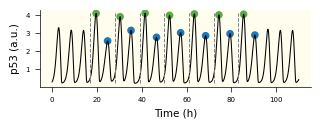

In [30]:
plot_period_doubling_model(
    x0 = [0.10605505, 1.38030638, 0.29319877],
    dt = 0.001,
    simT = 110,
    Aosc = 0.4,
    Tosc = 11,
    tON = 17,
    tOFF = 7*11+17,
    f_p53=f_p53,
    Pars=Pars,
    title="11h")

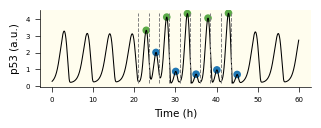

In [31]:
plot_period_doubling_model(
x0 = [0.10605505, 1.38030638, 0.29319877],
dt = 0.001,
simT = 60,
Aosc = 0.40,
Tosc = 2.5,
tON = 21,
tOFF = 10*2.5+21,
    f_p53=f_p53,
    Pars=Pars,
    title="25h")

# Figure 5C-E: Chaos single cell trace and strange attractor

In [32]:
# MODEL FOR CHAOS
Aosc = 0.48
Tnat = mean_T #6.02
Tosc = 2*mean_T
kc1, kc20,kc3,kc4,kc5,kc6,kc7 = unpack_Pars_list(Pars)

# EXPERIMENT
dt = 0.001
simT = 150*Tnat # [h]
t = np.arange(0, simT, dt) 
tON = 0
tOFF = simT
init_cond = np.array([0.10605505, 1.38030638, 0.29319877]) #np.array([0,0,0])#dmdt,dMdt,dpdt
eps = 0.5e-02
init_cond1 = init_cond + eps

x,kc2 = odeRungeKutta4_p53(f_p53,init_cond, dt, simT, Aosc, Tosc, tON, tOFF, kc1,kc20,kc3,kc4,kc5,kc6,kc7)
x1,kc2 = odeRungeKutta4_p53(f_p53,init_cond1, dt, simT, Aosc, Tosc, tON, tOFF, kc1,kc20,kc3,kc4,kc5,kc6,kc7)

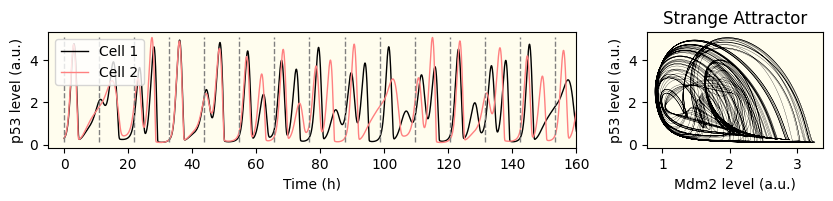

In [33]:
fig = plt.figure(figsize=(10,1.5))
gs = GridSpec(1, 2, width_ratios=[3, 1])  # 2 columns, 1 row, first plot 3 times wider

ax1 = fig.add_subplot(gs[0])
ax1.plot(t, x1[:,2], color = "black", label = "Cell 1", linewidth = 1)
ax1.plot(t, x[:,2], color = color_red_chaos_cell, label = "Cell 2", linewidth = 1)
ax1.legend(loc="upper left")
ax1.set_xlabel("Time (h)")
ax1.set_ylabel("p53 level (a.u.)")
ax1.set_facecolor(color_background)
#ax1.plot(t,kc2, "--", label = "kc2", color = "gray")
plt.xlim(left = -5, right=160)
#ax1.legend()
npulses = int(simT/Tosc)
time_nut_peaks = Tosc*np.arange(0,npulses,1)
ax1.vlines(time_nut_peaks, min(x[:,2]),max(x[:,2]), linestyle = '--', color = "gray", linewidth = 1)

ax2 = fig.add_subplot(gs[1])
ax2.set_title("Strange Attractor")
ax2.plot(x[-int(100*Tosc/dt):,1],x[-int(100*Tosc/dt):,2], color = "black", linewidth = 0.2)
ax2.set_xlabel("Mdm2 level (a.u.)"); ax2.set_ylabel("p53 level (a.u.)")
ax2.set_facecolor(color_background)
filename = f"Chaos_model_trace.svg"
plt.savefig("./Figures/"+filename)
plt.show()

# Figure 5D: Lyapunov exponent

#### Averaged over many initial conditions

In [36]:
Aosc = 0.48
Tnat = mean_T #6.02
Tosc = 2*mean_T
kc1, kc20,kc3,kc4,kc5,kc6,kc7 = unpack_Pars_list(Pars)

dt = 0.005
simT = 150*Tnat # [h]
tON = 0
tOFF = simT
init_cond = np.array([0, 0, 0])#dmdt,dMfreedt,dpdt,dMbounddt, dndt
eps = 1.0e-010
init_cond1 = init_cond + eps
t = np.arange(0, simT, dt) 


x,kc2 = odeRungeKutta4_p53(f_p53,init_cond, dt, simT, Aosc, Tosc, tON, tOFF, **Pars)
x1,kc2 = odeRungeKutta4_p53(f_p53,init_cond1, dt, simT, Aosc, Tosc, tON, tOFF, **Pars)

divergence_vec = []
for i in range(20): # I start 20 initial condition from the end of the previous simulations so I know I am in the strange attractor 
    init_cond = x[-1,:]
    init_cond1 = init_cond+eps
    x,kc2 = odeRungeKutta4_p53(f_p53,init_cond, dt, simT, Aosc, Tosc, tON, tOFF, **Pars)
    x1,kc2 = odeRungeKutta4_p53(f_p53,init_cond1, dt, simT, Aosc, Tosc, tON, tOFF, **Pars)
    divergence_vec.append(compute_lyap_div(x, x1, np.arange(0,simT,dt)))

Lyapunov exponent 0.0319+-1.083e-05


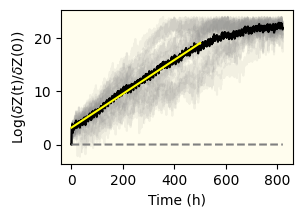

In [37]:
mean_divergence = np.mean(divergence_vec, axis = 0)
startpoint = 0
endpoint = int(500/dt)
lyapunov_exp, lyapunov_exp_error, lyapunov_exp_intercept = compute_lyap_exp(t,mean_divergence, endpoint = endpoint)
filename = "./Figures/Lyapunov_exp.svg"
plot_divergence_lyap_exp(divergence_vec, t, mean_divergence, startpoint, endpoint, lyapunov_exp, lyapunov_exp_intercept, lyapunov_exp_error,0.1,color_background,filename)

# Figure 5F: Period-doubling route to chaos

#### Simulations in series

In process: 100%|██████████| 2/2 [00:33<00:00, 16.67s/it]

Simulation completed in 33.42 seconds


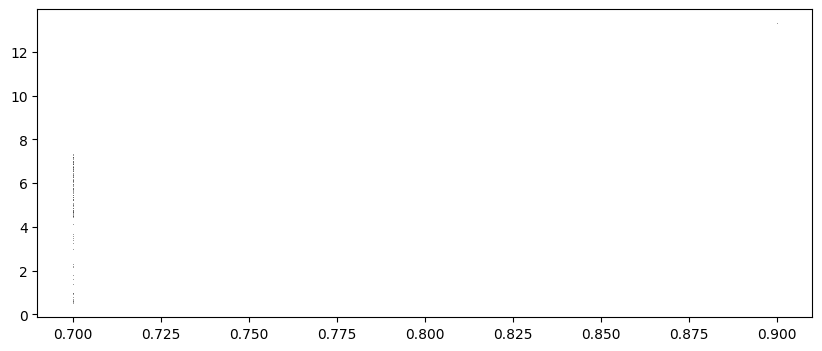

In [38]:
# Run simulations in series and save them
dt = 0.001
simT = 1000  # [h]
t = np.arange(0, simT, dt)
tON = 0
tOFF = simT

Tnat = mean_T 
Tosc = 2 * mean_T
Aosc_vec = np.linspace(0.7, 0.9, 2)
init_cond = np.array([1, 1, 0])  # dmdt,dMfreedt,dpdt,dMbounddt, dndt
x_list = []

# Initialize time tracking
start_time = time.time()

# Loop through Aosc_vec with progress bar
for Aosc in tqdm(Aosc_vec, desc="In process"):
    x, kc2 = odeRungeKutta4_p53(f_p53, init_cond, dt, simT, Aosc, Tosc, tON, tOFF, **Pars)
    x_list.append([Aosc,x])

# Calculate elapsed time
elapsed_time = time.time() - start_time
print("Simulation completed in {:.2f} seconds".format(elapsed_time))

unique_peaks_vec = find_peaks_for_period_doubling(t, x_list, [], transient = 100)
#plot_period_doubling(Aosc_vec, unique_peaks_vec)

#### Simulations in parallel

In [39]:
## Plot simulations that were run in parallel in Period_doubling.py
from Period_doubling_pars import *

unique_peaks_vec = []
for i in np.arange(2,49):
    with open(f"./Output/Period_doublin/Aosc_500_dt_{i}.pkl", 'rb') as f:
        # Load the data from the file
        x_list = pickle.load(f)
    dt = simulation_parameters["dt"]
    simT = simulation_parameters["simT"]
    t = np.arange(0,simT,dt)
    unique_peaks_vec = find_peaks_for_period_doubling(t, x_list, unique_peaks_vec, transient = 500)

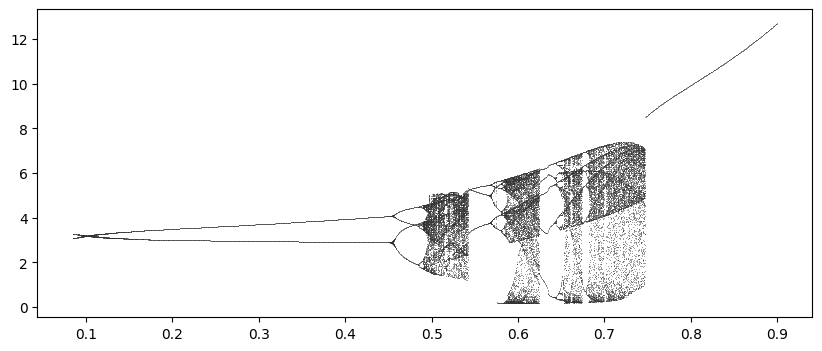

<Figure size 640x480 with 0 Axes>

In [40]:
plot_period_doubling(simulation_parameters["Aosc_vec"][167:], unique_peaks_vec)
#plt.box(None)
#plt.xticks([])  # Remove xticks
#plt.yticks([])  # Remove yticks
#plt.xlim([0.05,0.8])
plt.show()
plt.savefig("./Figures/Period-doubling.svg")

### Plot single cell traces in model for period-doubling route to chaos

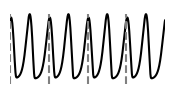

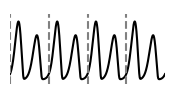

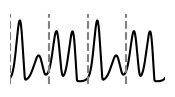

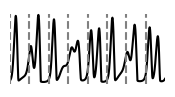

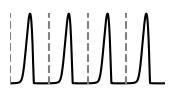

In [41]:
from Period_doubling_pars import *
Aosc_vec = [0.05,0.3,0.45,0.5,0.8]
numpeaks = [4,4,4,8,4]
npulses = 20
simT = npulses*simulation_parameters["Tosc"]
for i,Aosc in enumerate(Aosc_vec):
    x,kc2 = odeRungeKutta4_p53(f_p53,simulation_parameters["x0"], 
                            simulation_parameters["dt"], simT, 
                            Aosc, simulation_parameters["Tosc"], 
                                simulation_parameters["tON"], simulation_parameters["tOFF"], **Pars)
    fig,ax = plt.subplots(figsize=(2,1))
    ax.plot(np.arange(0,simT,simulation_parameters["dt"]), x[:,2], label = "p53", color = "black")
    time_nut_peaks = simulation_parameters["Tosc"]*np.arange(0,npulses,1)
    plt.vlines(time_nut_peaks, min(x[:,2]),max(x[:,2]), linestyle = '--', color = "gray")
    plt.xlim([time_nut_peaks[-numpeaks[i]],simT])
    plt.box(None)
    plt.xticks([])
    plt.yticks([])
    plt.savefig("./Figures/Model_period_doubling_boxes"+str(Aosc)+".svg")
    plt.show()